In [1]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

cuda:0


In [2]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/')
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import plate_modules
from plate_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *


import importlib
plate_modules=importlib.reload(plate_modules)
from plate_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


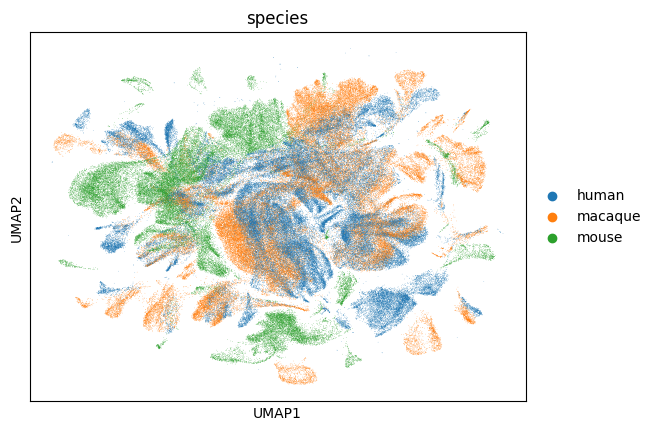

In [3]:
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvM_900k_RPCA_clusters.h5ad'))
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part1.h5ad'),backed='r')
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall.h5ad'),backed='r')

adata.obsm["X_original_umap"]=adata.obsm["X_umap"]
sc.pl.umap(adata,color='species')

<Axes: xlabel='general_region'>

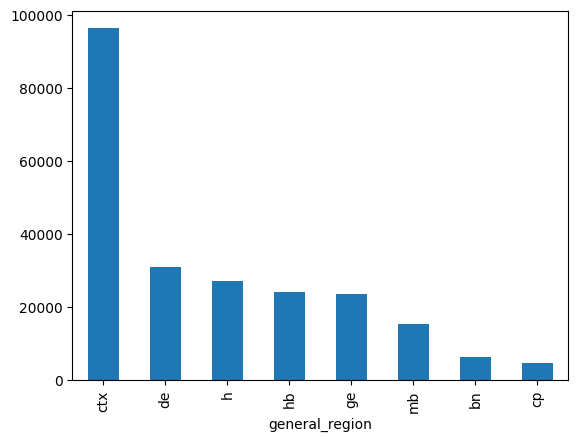

In [4]:
adata.obs['general_region'].value_counts().plot.bar()
#adata.obs['sample_region'].value_counts().plot.bar()
#adata.obs.groupby('species')['sample_region'].value_counts(normalize=True).unstack().T.plot.bar()

# Setting up the model

In [5]:
class AntipodeTrainingMixin:
    '''can use supervised taxonomy by training only phase2'''
    
    def save_params_to_uns(self,prefix=''):
        pstore=param_store_to_numpy()
        pstore={n:pstore[n] for n in pstore.keys() if not re.search('encoder|classifier',n)}
        self.adata_manager.adata.uns[prefix+'param_store']=pstore

    def store_outputs(self,device='cuda',prefix=''):
        self.save_params_to_uns(prefix='')
        self.to('cpu')
        self.eval()
        antipode_outs=get_antipode_outputs(self,batch_size=2048,device=device)
        taxon=antipode_outs[1][0]
        adata.obsm['X_antipode']=antipode_outs[0][0]
        level_edges=[numpy_hardmax(self.adata_manager.adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(self.level_sizes)-1)]
        levels=self.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-self.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
        prop_taxon=np.concatenate(levels,axis=-1)
        adata.obsm['taxon_probs']=prop_taxon
        levels=self.tree_convergence_bottom_up.just_propagate(numpy_hardmax(levels[-1],axis=-1),level_edges,s=torch.ones(1))
        for i in range(len(levels)):
            cur_clust=prefix+'level_'+str(i)
            self.adata_manager.adata.obs[cur_clust]=levels[i].argmax(1)
            self.adata_manager.adata.obs[cur_clust]=adata.obs[cur_clust].astype(str)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs.apply(lambda x: '_'.join([x[prefix+'level_'+str(i)] for i in range(len(levels))]), axis=1)
    
    def train_phase_1(self,max_steps,print_every=10000,device='cuda',max_learning_rate=0.001,num_particles=3,one_cycle_lr=True,steps=0,batch_size=32):
        #particle phase
        steps=steps
        print(self.fields)
        print(self.field_types)
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=32,drop_last=True,shuffle=True,data_and_attributes=self.field_types)#supervised_field_types for supervised step
        scheduler=pyro.optim.OneCycleLR({'max_lr':max_learning_rate,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam}) if one_cycle_lr else pyro.optim.ClippedAdam({'lr':max_learning_rate,'lrd':(1-(5e-6))})
        elbo = pyro.infer.JitTrace_ELBO(num_particles=num_particles,strict_enumeration_warning=False)
        svi = SVI(self.model, self.guide, scheduler, elbo)
        self.train()
        self.zl_encoder.train()
        
        self=self.to(device)
        self.set_approx(True)
        loss_tracker=[]
        pbar = tqdm.tqdm(total=max_steps, position=0)
        done=False
        while steps < max_steps:
            for x in dataloader:
                x['step']=torch.ones(1).to(device)*steps
                x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                loss=svi.step(*x)
                steps+=1
                if steps<max_steps-1:
                    scheduler.step()
                else:
                    break
                pbar.update(1)
                loss_tracker.append(loss)
                if steps%print_every == 0:
                    # Tell the scheduler we've done one epoch.
                    pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
        
        pbar.close()
        allDone()
        print("Finished training!")

    def prepare_phase_2(self):
        '''Run this if not running in supervised only mode (JUST phase2 with provided obsm clustering), runs kmeans, resets tree edges and locs'''
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=self.level_sizes[-1],init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(self.adata_manager.adata.obsm['X_antipode'])
        adata.obs['kmeans']=kmeans.labels_
        adata.obs['kmeans']=adata.obs['kmeans'].astype(str).astype('category')
        adata.obsm['kmeans_onehot']=numpy_onehot(adata.obs['kmeans'].cat.codes,num_classes=self.level_sizes[-1]) #yoh=yoh+1e-10;yoh=oh/oh.sum(-1).reshape(-1,1)#for relaxed
        new_locs=torch.concatenate(
            [pyro.param('locs').new_zeros(sum(self.level_sizes[:-1]),pyro.param('locs').shape[1]),
             torch.tensor(kmeans.cluster_centers_,device=pyro.param('locs').device)],
             axis=0)
        pyro.get_param_store().__setitem__('locs',new_locs)
        pyro.get_param_store().__setitem__('locs_dynam',new_locs.new_zeros(new_locs.shape))
        for n in pyro.get_param_store():
            if 'edge' in n:
                pyro.get_param_store().__setitem__(n,pyro.param(n).new_zeros(pyro.param(n).shape))
        
    def train_phase_2(self,max_steps,taxon_label='kmeans_onehot',print_every=10000,device='cuda',max_learning_rate=0.001,num_particles=1,one_cycle_lr=False,steps=0,batch_size=32):
        '''empirically works best and fastest with one_cycle_lr=False'''
        steps=steps
        supervised_field_types=self.field_types.copy()
        supervised_fields=self.fields.copy()
        supervised_field_types["taxon"]=np.float32
        self.adata_manager.register_new_fields([make_field('taxon',('obsm',taxon_label))])
        class_dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=batch_size,drop_last=True,shuffle=True,data_and_attributes=supervised_field_types)
        scheduler=pyro.optim.OneCycleLR({'max_lr':max_learning_rate,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam}) if one_cycle_lr else pyro.optim.ClippedAdam({'lr':max_learning_rate,'lrd':(1-(5e-6))})
        elbo = pyro.infer.JitTrace_ELBO(num_particles=num_particles,strict_enumeration_warning=False)
        svi = SVI(self.model, self.guide, scheduler, elbo)
        
        self.train()
        self=self.to(device)
        self.set_approx(False)
        loss_tracker=[]
        #for steps in range(max_steps):
        pbar = tqdm.tqdm(total=max_steps, position=0)
        done=False
        while steps < max_steps:
            for x in class_dataloader:
                x['step']=torch.ones(1).to(device)*steps
                x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                loss=svi.step(*x)
                steps+=1
                if steps<=max_steps-1:
                    #scheduler.step()
                    pass
                else:
                    break
                pbar.update(1)
                loss_tracker.append(loss)
                if steps%print_every == 0:
                    # Tell the scheduler we've done one epoch.
                    pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
        
        pbar.close()
        allDone()
        print("Finished training!")

    def train_phase_3(self,max_steps,print_every=10000,device='cuda',max_learning_rate=0.001,num_particles=3,one_cycle_lr=True,steps=0,batch_size=32):
        steps=steps
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=batch_size,drop_last=True,shuffle=True,data_and_attributes=self.field_types)#supervised_field_types for supervised step
        scheduler=pyro.optim.OneCycleLR({'max_lr':max_learning_rate,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam}) if one_cycle_lr else pyro.optim.ClippedAdam({'lr':max_learning_rate,'lrd':(1-(5e-6))})
        elbo = pyro.infer.JitTraceEnum_ELBO(num_particles=num_particles,strict_enumeration_warning=False)
        svi = SVI(self.model, self.guide, scheduler, elbo)

        loss_tracker=[]
        self.train()
        self=self.to(device)
        self.set_approx(False)
        
        #for steps in range(max_steps):
        pbar = tqdm.tqdm(total=max_steps, position=0)
        done=False
        while steps < max_steps:
            for x in dataloader:
                x['step']=torch.ones(1).to(device)*steps
                x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                loss=svi.step(*x)
                steps+=1
                if steps<max_steps-1:
                    #scheduler.step()
                    pass
                else:
                    break
                pbar.update(1)
                loss_tracker.append(loss)
                if steps%print_every == 0:
                    # Tell the scheduler we've done one epoch.
                    pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))
        
        pbar.close()
        allDone()
        print("Finished training!")



In [6]:
from scvi.module.base import PyroBaseModuleClass

class ANTIPODE(PyroBaseModuleClass,AntipodeTrainingMixin):#
    '''
    ANTIPODE (Single Cell Ancestral Node Taxonomy Inference by Parcellation of Differential Expression) 
    is a variational inference model developed for the simultaneous analysis (DE) and 
    categorization (taxonomy generation) of cell types across evolution (or now any covariate) using single-cell RNA-seq data.
    

    Parameters:
    adata (AnnData): An AnnData object containing the single-cell dataset.
    discov_pair (tuple): A tuple indicating the key and location of the discovery covariate 
                         in the AnnData object. Format: ('key', 'location'), where location is 
                         either 'obs' or 'obsm'.
    batch_pair (tuple): A tuple indicating the key and location of the batch covariate 
                        in the AnnData object. Format: ('key', 'location'), where location is 
                        either 'obs' or 'obsm'.
    num_var (int): Number of variables (features) in the dataset.
    level_sizes (list of int, optional): Sizes of each level in the model's hierarchical structure. 
                                         Defaults to [1, 10, 25, 50].
    num_latent (int, optional): Number of latent dimensions. Defaults to 50.
    scale_factor (float, optional): Scaling factor for data normalization. If None, it is inferred from the data.
    prior_scale (float, optional): Scale of the Laplace prior distributions. Defaults to 100.
    dcd_prior (float, optional): Scale of the prior for the decoder. If None, defaults to a specific inferred value.
    decay_function (callable, optional): A function that defines the decay of certain parameters over iterations.
    max_strictness (float, optional): Maximum strictness parameter for tree convergence. Defaults to 1.
    bi_depth (int, optional): Depth of the tree for the approximation of batch by identity effects. Defaults to 2.
    num_batch_embed (int, optional): Number of batch embeddings. Defaults to 10.
    classifier_hidden (list of int, optional): Sizes of hidden layers for the classifier network. Defaults to [3000, 3000, 3000].
    encoder_hidden (list of int, optional): Sizes of hidden layers for the encoder network. Defaults to [6000, 5000, 3000, 1000].
    '''
    def __init__(self, adata, discov_pair, batch_pair, layer, num_var, level_sizes=[1, 10, 25, 50], 
                 num_latent=50, scale_factor=None, prior_scale=100,dcd_prior=None,
                 decay_function=None, max_strictness=1., bi_depth=2, num_batch_embed=10,
                 classifier_hidden=[3000,3000,3000],encoder_hidden=[6000,5000,3000,1000]):
        
        # Determine num_discov and num_batch from the AnnData object
        self.discov_loc, self.discov_key = discov_pair
        self.batch_loc, self.batch_key = batch_pair
        self.num_discov = adata.obsm[self.discov_key].shape[-1] if self.discov_loc == 'obsm' else len(adata.obs[self.discov_key].unique())
        self.num_batch = adata.obsm[self.batch_key].shape[-1] if self.batch_loc == 'obsm' else len(adata.obs[self.batch_key].unique())
        self.design_matrix = (self.discov_loc == 'obsm')
        self.layer=layer

        self._setup_adata_manager_store: dict[str, type[scvi.data.AnnDataManager]] = {}
        self.num_var = adata.layers[layer].shape[-1]
        self.num_latent = num_latent
        self.scale_factor = scale_factor if scale_factor is not None else 2e2 / (num_var * num_labels * num_latent)
        self.level_sizes = level_sizes
        self.num_labels = np.sum(self.level_sizes)
        self.level_indices = np.cumsum([0] + self.level_sizes)
        self.bi_depth = bi_depth
        self.num_bi_depth = sum(self.level_sizes[:self.bi_depth])
        self.num_batch_embed = num_batch_embed
        self.max_strictness = 1.
        self.decay_function = gen_linear_function(max_steps,10000) if decay_function is None else decay_function 
        self.temperature = 0.1
        self.epsilon = 0.006
        self.approx = False
        self.prior_scale = prior_scale
        
        self.dcd_prior=torch.zeros((self.num_discov,self.num_var)) if dcd_prior is None else dcd_prior#Use this for 
        
        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.discov_plate=pyro.plate('discov_plate',self.num_discov,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)
        self.bi_depth_plate=pyro.plate('bi_depth_plate',self.num_bi_depth,dim=-2)

        #Initialize MAP inference modules
        self.dm=MAPLaplaceModule(self,'discov_dm',[self.num_discov,self.num_labels,self.num_latent],[self.discov_plate,self.label_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch,self.num_labels,self.num_latent],[self.batch_plate,self.label_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'discov_di',[self.num_discov,self.num_labels,self.num_var],[self.discov_plate,self.label_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.num_bi_depth,self.num_var],[self.batch_embed_plate,self.bi_depth_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_labels, self.num_var],[self.label_plate,self.var_plate])
        self.dc=MAPLaplaceModule(self,'discov_dc',[self.num_discov,self.num_latent,self.num_var],[self.discov_plate,self.latent_plate2,self.var_plate])
        self.zdw=MAPLaplaceModule(self,'z_decoder_weight',[self.num_latent,self.num_var],[self.latent_plate2,self.var_plate],init_val=((2/self.num_latent)*(torch.rand(self.num_latent,self.num_var)-0.5)),param_only=False)
        self.zl=MAPLaplaceModule(self,'locs',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=False)
        self.zs=MAPLaplaceModule(self,'scales',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],init_val=0.01*torch.ones(self.num_labels,self.num_latent),constraint=constraints.positive,param_only=False)
        self.zld=MAPLaplaceModule(self,'locs_dynam',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=False)
        
        self.tree_edges=TreeEdges(self,straight_through=True)
        self.tree_convergence=TreeConvergence(self,strictness=1.)        
        self.tree_convergence_bottom_up=TreeConvergenceBottomUp(self,strictness=1.)        
        self.z_transform=null_function#centered_sigmoid#torch.special.expit

        if self.design_matrix:
            fields={'s':('layers','spliced'),
            'discov_ind':('obsm','discov_onehot'),
            'batch_ind':('obsm','batch_onehot')}
            field_types={"s":np.float32,"batch_ind":np.float32,"discov_ind":np.float32}
        else:
            fields={'s':('layers','spliced'),
            'discov_ind':('obs','species'),
            'batch_ind':('obs','batch_name')}
            field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64}

        self.fields=fields
        self.field_types=field_types
        self.setup_anndata(adata, {'discov_ind': discov_pair, 'batch_ind': batch_pair}, self.field_types)
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=num_var,hidden_dims=encoder_hidden,num_cat_input=self.num_discov,
                    outputs=[(self.num_latent,None),(self.num_latent,softplus)])
        
        self.classifier=Classifier(num_latent=self.num_latent,hidden_dims=classifier_hidden,
                    outputs=[(self.num_labels,None),(1,None),(1,softplus)])

        #self.bc_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[200,200,50,5],
        #            out_dim=self.num_var*self.num_latent)
        #Too large to exactly model gene-level batch effects for all cluster x batch
        self.be_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[1000,500,500],
                    out_dim=self.num_batch_embed)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        self.prior_scale=prior_scale
        self.args=inspect.getfullargspec(self.model).args[1:]#skip self

    def setup_anndata(self,adata: anndata.AnnData,fields,field_types,**kwargs,):
        
        anndata_fields=[make_field(x,self.fields[x]) for x in self.fields.keys()]
        
        adata_manager = scvi.data.AnnDataManager(
            fields=anndata_fields
        )
        adata_manager.register_fields(adata, **kwargs)
        self.register_manager(adata_manager)
        if fields['discov_ind'][0]=='obsm':
            self.design_matrix=True
            if fields['batch_ind'][0]!='obsm':
                raise Exception("If discov is design matrix, batch must be as well!")


    def register_manager(self, adata_manager: scvi.data.AnnDataManager):
        adata_id = adata_manager.adata_uuid
        self._setup_adata_manager_store[adata_id] = adata_manager
        self.adata_manager=adata_manager
    
    def set_approx(self,b: bool):
        self.approx=b
        
    def model(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)

        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0],dim=-1)
        minibatch_plate2=pyro.plate("minibatch_plate2", s.shape[0],dim=-2)
        cur_strictness=self.decay_function(step, self.max_strictness)
        l = s.sum(1).unsqueeze(-1)
        
        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with poutine.scale(scale=self.scale_factor):
            # This gene-level parameter modulates the variance of the observation distribution
            s_theta = pyro.param("s_inverse_dispersion", 50.0 * s.new_ones(self.num_var),
                               constraint=constraints.positive)
            
            dcd=pyro.param("discov_constitutive_de", self.dcd_prior.to(s.device))
            level_edges=self.tree_edges.model_sample(s,approx=self.approx)
            
            with minibatch_plate:
                beta_prior_a=1.*s.new_ones(self.num_labels)
                beta_prior_a[0]=10.
                if self.approx:#Bernoulli particles approx?
                    taxon_probs = pyro.sample("taxon_probs", dist.Beta(beta_prior_a,s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=taxon_probs).to_event(1))
                    #self.tree_convergence.model_sample(taxon,level_edges,s,cur_strictness)#Someday will be possible to properly generate Undirected acyclic graphs here
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Dirichlet(s.new_ones(s.shape[0],self.level_sizes[-1]),validate_args=True))
                    if sum(taxon.shape) > 1:#Supervised?
                        if taxon.shape[-1]==self.num_labels:#Totally supervised?
                            pass
                        else:#Only bottom layer is supervised?
                            taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),obs=taxon)
                            taxon = torch.concat(self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s),-1)
                    else:#Unsupervised
                        taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),infer={'enumerate':'parallel'})
                        taxon = torch.concat(self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s),-1)
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs,level_edges,s,cur_strictness)
                    taxon_probs=torch.cat(taxon_probs,-1)
                   
            locs=self.zl.model_sample(s)
            scales=self.zs.model_sample(s)
            locs_dynam=self.zld.model_sample(s)
            discov_dm=self.dm.model_sample(s,scale=fest([discov,taxon_probs],-1))
            discov_di=self.di.model_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.model_sample(s,scale=fest([batch,taxon_probs],-1))
            batch_embed=torch.sigmoid(self.be_nn(batch))
            bei=self.bei.model_sample(s,scale=fest([batch_embed,taxon_probs[...,:self.num_bi_depth]],-1))
            cluster_intercept=self.ci.model_sample(s,scale=fest([taxon_probs],-1))
            z_decoder_weight=self.zdw.model_sample(s)
            
            with minibatch_plate:
                bi=torch.einsum('...bi,...ijk->...bjk',batch_embed,bei)
                bi=torch.einsum('...bj,...bjk->...bk',taxon[...,:self.num_bi_depth],bi)
                psi = centered_sigmoid(pyro.sample('psi',dist.Laplace(s.new_zeros(s.shape[0],1),self.prior_scale*s.new_ones(s.shape[0],1)).to_event(1)))#Used to be normal#maybe should be centered sigmoid
                this_locs=oh_index(locs,taxon)
                this_scales=oh_index(scales,taxon)
                z=pyro.sample('z', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))

            cur_discov_dm = oh_index1(discov_dm, discov_ind) if self.design_matrix else discov_dm[discov_ind]
            cur_batch_dm = oh_index1(batch_dm, batch_ind) if self.design_matrix else batch_dm[batch_ind]
            cur_dcd = oh_index(dcd, discov) if self.design_matrix else  dcd[discov_ind]
            
            z=z+oh_index2(cur_discov_dm,taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)                
            fake_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(batch_dm[batch_ind],taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            discov_dc=self.dc.model_sample(s,scale=fest([discov,fake_z.abs()],-1))
            cur_discov_di = oh_index1(discov_di, discov_ind) if self.design_matrix else discov_di[discov_ind]
            cur_discov_dc = oh_index1(discov_dc, discov_ind) if self.design_matrix else discov_dc[discov_ind]
            cur_discov_di=oh_index2(cur_discov_di,taxon)
            cur_cluster_intercept=oh_index(cluster_intercept,taxon)
            
            mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+cur_discov_dc)#+bc
            spliced_mu=mu+cur_dcd+cur_discov_di+cur_cluster_intercept+bi
            spliced_out=torch.softmax(spliced_mu,dim=-1)
            log_mu = (l * spliced_out + 1e-6).log()
            
            with self.var_plate,minibatch_plate2:
                s_dist = dist.NegativeBinomial(total_count=s_theta,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist, obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        pyro.module("antipode", self)
        
        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0])
        cur_strictness=self.decay_function(step, self.max_strictness)
        
        with poutine.scale(scale=self.scale_factor):
            locs=self.zl.guide_sample(s)
            scales=self.zs.guide_sample(s)
            locs_dynam=self.zld.guide_sample(s)
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx) 
            with minibatch_plate:
                z_loc, z_scale= self.zl_encoder(s,discov)
                z=pyro.sample('z',dist.Normal(z_loc,z_scale+self.epsilon).to_event(1))
                z=self.z_transform(z)
                taxon_logits,psi_loc,psi_scale=self.classifier(z)
                psi=centered_sigmoid(pyro.sample('psi',dist.Normal(psi_loc,psi_scale).to_event(1)))
                if self.approx:
                    taxon_dist = dist.Delta(safe_sigmoid(taxon_logits),validate_args=True).to_event(1)
                    taxon_probs = pyro.sample("taxon_probs", taxon_dist)
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=taxon_probs).to_event(1))
                    #self.tree_convergence.guide_sample(taxon,level_edges,s,cur_strictness)
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Delta(safe_softmax(taxon_logits[...,-self.level_sizes[-1]:])).to_event(1))
                    if sum(taxon.shape) > 1:
                        pass
                    else:
                        taxon = pyro.sample("taxon", 
                                         dist.OneHotCategorical(probs=taxon_probs,validate_args=True),infer={'enumerate':'parallel'})                    
                    if taxon.shape[-1]<self.num_labels:
                        taxon = torch.concat(self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s),-1)

                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s,cur_strictness)
                    taxon_probs=torch.cat(taxon_probs,-1)
                
            z_decoder_weight=self.zdw.guide_sample(s)
            discov_dm=self.dm.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.guide_sample(s,scale=fest([batch,taxon_probs],-1))
            batch_embed=torch.sigmoid(self.be_nn(batch))
            discov_di=self.di.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            cluster_intercept=self.ci.guide_sample(s,scale=fest([taxon_probs],-1))
            bei=self.bei.guide_sample(s,scale=fest([batch_embed,taxon_probs[...,:self.num_bi_depth]],-1))#maybe should be abs sum bei
            if self.design_matrix:
                z=z+oh_index2(oh_index1(discov_dm,discov_ind),taxon) + oh_index2(oh_index1(batch_dm,batch_ind),taxon)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(discov_dm[discov_ind],taxon) + oh_index2(batch_dm[batch_ind],taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)
            fake_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(batch_dm[batch_ind],taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            discov_dc=self.dc.guide_sample(s,scale=fest([discov,fake_z.abs()],-1))


In [7]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [8]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,25,75,250]
num_latent=200
num_labels=sum(level_sizes)
steps=0
max_steps=100000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

decay_function=gen_linear_function(max_steps,10000)#gen_exponential_decay(5e-6)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_var=num_var, num_latent=num_latent,level_sizes=level_sizes,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch_name'),layer='spliced',
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),
                bi_depth=2,decay_function=decay_function,max_strictness=100,prior_scale=100.,num_batch_embed=10)


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

I0000 00:00:1706515910.936153  227560 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 0 in adata.obs['_scvi_batch_ind'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [9]:
antipode_model.train_phase_1(max_steps=10,print_every=10000)
antipode_model.store_outputs(device=device,prefix='phase_1_')
antipode_model.prepare_phase_2()
antipode_model.train_phase_2(max_steps=10,print_every=10000)
antipode_model.store_outputs(device=device,prefix='phase_2_')
antipode_model.train_phase_3(max_steps=10,print_every=10000)
antipode_model.store_outputs(device=device,prefix='phase_3_')

{'s': ('layers', 'spliced'), 'discov_ind': ('obs', 'species'), 'batch_ind': ('obs', 'batch_name')}
{'s': <class 'numpy.float32'>, 'batch_ind': <class 'numpy.int64'>, 'discov_ind': <class 'numpy.int64'>}


  0%|          | 0/10 [00:00<?, ?it/s]<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data fl

Finished training!
INFO     Generating sequential column names                                                                        


100%|██████████| 112/112 [00:00<00:00, 156.68it/s]


INFO     Generating sequential column names                                                                        


  0%|          | 0/10 [00:00<?, ?it/s]/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py

Finished training!
INFO     Generating sequential column names                                                                        


  0%|          | 0/10 [00:00<?, ?it/s]/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py:218: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py:221: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/home/matthew.schmitz/Matthew/code/scANTIPODE/dev_versions/plate_version/model_functions.py

Finished training!
INFO     Generating sequential column names                                                                        


100%|██████████| 112/112 [00:00<00:00, 155.31it/s]


In [10]:
erwq

NameError: name 'erwq' is not defined

In [11]:
import yaml

def load_env(filename):
    with open(filename, 'r') as file:
        env = yaml.load(file, Loader=yaml.SafeLoader)
    return {pkg.split('=')[0]: pkg for pkg in env['dependencies'] if '=' in pkg}

def compare_envs(env1, env2):
    env1_packages = load_env(env1)
    env2_packages = load_env(env2)

    all_packages = set(env1_packages.keys()) | set(env2_packages.keys())

    for pkg in sorted(all_packages):
        version1 = env1_packages.get(pkg, 'Not installed')
        version2 = env2_packages.get(pkg, 'Not installed')

        if version1 != version2:
            print(f"{pkg:30} {version1:30} {version2}")

# Usage
compare_envs('/home/matthew.schmitz/pyro.yml', '/home/matthew.schmitz/pyro2.yaml')


_libgcc_mutex                  _libgcc_mutex=0.1=conda_forge  _libgcc_mutex=0.1=main
_openmp_mutex                  _openmp_mutex=4.5=2_gnu        _openmp_mutex=5.1=1_gnu
backcall                       backcall=0.2.0=pyhd3eb1b0_0    Not installed
binutils_impl_linux-64         binutils_impl_linux-64=2.40=hf600244_0 Not installed
brotli-python                  brotli-python=1.0.9=py311h6a678d5_7 Not installed
ca-certificates                ca-certificates=2023.08.22=h06a4308_0 ca-certificates=2023.11.17=hbcca054_0
certifi                        certifi=2023.7.22=py311h06a4308_0 Not installed
cffi                           cffi=1.15.1=py311h5eee18b_3    Not installed
charset-normalizer             charset-normalizer=2.0.4=pyhd3eb1b0_0 Not installed
cryptography                   cryptography=41.0.3=py311hdda0065_0 Not installed
cuda-cudart                    cuda-cudart=11.7.99=0          cuda-cudart=12.1.105=0
cuda-cupti                     cuda-cupti=11.7.101=0          cuda-cupti=12.1

# Training Phase 1: Particlized tree approximation

In [ ]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,25,75,250]
num_latent=200
num_labels=sum(level_sizes)
steps=0
max_steps=100000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(True)

decay_function=gen_linear_function(max_steps,10000)#gen_exponential_decay(5e-6)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_var=num_var, num_latent=num_latent,level_sizes=level_sizes,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch_name'), layer='spliced',
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),
                bi_depth=2,decay_function=decay_function,max_strictness=100,prior_scale=100.,num_batch_embed=10)



In [ ]:
"""
#For weighted sampler
class_weights = adata.obs['region_species'].astype('category').cat.codes.value_counts(normalize=False,sort=False).sort_index()
labels = list(adata.obs['region_species'].astype('category').cat.codes) #corresponding labels of samples
weights = [1/class_weights[labels[i]] for i in range(len(labels))]
sampler = torch.utils.data.sampler.WeightedRandomSampler(torch.DoubleTensor(weights),len(weights),replacement=True)
"""

scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})
elbo = pyro.infer.JitTrace_ELBO(num_particles=1,strict_enumeration_warning=False)
svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

design_matrix=False  #3x faster if false
if design_matrix:
    #Place complex batch and categorical covariate (design matrix) in obsm, else use obs categorical
    adata.obsm['discov_onehot']=numpy_onehot(adata.obs['species'].cat.codes)
    adata.obsm['batch_onehot']=numpy_onehot(adata.obs['batch_name'].cat.codes)
    fields={'s':('layers','spliced'),
    'discov_ind':('obsm','discov_onehot'),
    'batch_ind':('obsm','batch_onehot')}
    field_types={"s":np.float32,"batch_ind":np.float32,"discov_ind":np.float32}
else:
    adata.obsm['discov_onehot']=numpy_onehot(adata.obs['species'].cat.codes)
    adata.obsm['batch_onehot']=numpy_onehot(adata.obs['batch_name'].cat.codes)
    fields={'s':('layers','spliced'),
    'discov_ind':('obs','species'),
    'batch_ind':('obs','batch_name')}
    field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64}

antipode_model.setup_anndata(adata,fields,field_types)
dataloader=scvi.dataloaders.AnnDataLoader(antipode_model.adata_manager,batch_size=32,drop_last=True,shuffle=True,data_and_attributes=field_types)#supervised_field_types for supervised step
#SemiSupervisedDataLoader
#scvi.dataloaders.SemiSupervisedDataLoader()

In [ ]:
antipode_model.adata_manager.registry

In [ ]:
antipode_model.train()
antipode_model.zl_encoder.train()

antipode_model=antipode_model.to(device)
antipode_model.set_approx(True)
loss_tracker=[]
#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for x in dataloader:
        x['step']=torch.ones(1).to(device)*steps
        #x={k:x[k].to(device) for k in x.keys()}
        x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in antipode_model.args]
        loss=svi.step(*x)
        steps+=1
        if steps<max_steps-1:
            scheduler.step()
        else:
            break
        pbar.update(1)
        loss_tracker.append(loss)
        if not done:
            done=True
            print('grad tracking')
            gradient_norms = defaultdict(list)
            for name, value in pyro.get_param_store().named_parameters():
                value.register_hook(
                    lambda g, name=name: gradient_norms[name].append(g.norm().item())
                )
        if steps%print_every == 0:
            # Tell the scheduler we've done one epoch.
            pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

In [ ]:
import numpy as np
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [ ]:
antipode_model.adata_manager.adata.uns['param_store']=param_store_to_numpy()

In [ ]:
plot_gmm_heatmaps(antipode_model)

In [ ]:
plot_tree_edge_weights(antipode_model)

In [ ]:
plot_d_hists(antipode_model)

In [ ]:
# Put the neural networks in evaluation mode (needed because of batch norm)
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_antipode_outputs(antipode_model,batch_size=2048,device=device)

In [ ]:
clusternames=[str(i) for i in range(antipode_model.num_latent)]
adata.obs['max_component']=np.array(clusternames)[antipode_outs[0][0].argmax(1)]

adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
sc.pl.umap(adata,color=['max_component'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
seaborn.clustermap(np.corrcoef(antipode_outs[0][0].T))

In [ ]:
taxon=antipode_outs[1][0]

nottree_levels = [taxon[..., antipode_model.level_indices[i]:antipode_model.level_indices[i + 1]]
          for i in range(len(antipode_model.level_sizes))]

for i, level in enumerate(nottree_levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the nottree_levels to form the cluster label
adata.obs['antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(nottree_levels))]), axis=1)

level_edges=[numpy_hardmax(adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(numpy_hardmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    adata.obs['prop_level_'+str(i)]=levels[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['prop_level_'+str(i)].astype(str)

prop_taxon=np.concatenate(levels,axis=-1)
adata.obs['prop_antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['prop_level_' + str(i)] for i in range(len(levels))]), axis=1)

sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

seaborn.clustermap(prop_taxon[:10000,:],row_cluster=False)

In [ ]:
taxon=antipode_outs[1][0]
adata.obsm['X_antipode_model']=antipode_outs[0][0]


In [ ]:
adata.obsm['X_antipode_model']=antipode_outs[0][0]
adata.obs['psi']=antipode_outs[1][1]
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode_model")
sc.tl.umap(xdata)

In [ ]:
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:

xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 2: Inintializing categorical leaved tree

In [ ]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=antipode_model.level_sizes[-1],init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(antipode_model.adata_manager.adata.obsm['X_antipode_model'])
adata.obs['kmeans']=kmeans.labels_
adata.obs['kmeans']=adata.obs['kmeans'].astype(str)
sc.pl.umap(adata,color=['kmeans','leiden'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)

In [ ]:
#reset params for categorical
for n in pyro.get_param_store():
    if 'edge' in n:
        print(pyro.param(n))
        pyro.get_param_store().__setitem__(n,pyro.param(n).new_zeros(pyro.param(n).shape))

new_locs=torch.concatenate(
    [pyro.param('locs').new_zeros(sum(antipode_model.level_sizes[:-1]),pyro.param('locs').shape[1]),
     torch.tensor(kmeans.cluster_centers_,device=pyro.param('locs').device)],
     axis=0)
pyro.get_param_store().__setitem__('locs',new_locs)
pyro.get_param_store().__setitem__('locs_dynam',new_locs.new_zeros(new_locs.shape))


In [ ]:
supervised_fields={'s':('layers','spliced'),
'discov_ind':('obs','species'),
'batch_ind':('obs','batch_name'),
'taxon':('obsm','kmeans_onehot')}
adata.obsm['kmeans_onehot']=numpy_onehot(adata.obs['kmeans'].cat.codes,num_classes=antipode_model.level_sizes[-1]) #yoh=yoh+1e-10;yoh=oh/oh.sum(-1).reshape(-1,1)#for 
antipode_model.adata_manager.register_new_fields([make_field('taxon',('obsm','kmeans_onehot'))])

supervised_field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64,"taxon":np.float32}
class_dataloader=scvi.dataloaders.AnnDataLoader(antipode_model.adata_manager,batch_size=32,drop_last=True,shuffle=True,data_and_attributes=supervised_field_types)#supervised_field_types for supervised step 

#Also need to reset SVI
scheduler =pyro.optim.ClippedAdam({'lr':0.001,'lrd':(1-(7e-6))})
#scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})
elbo = pyro.infer.JitTrace_ELBO(num_particles=1,strict_enumeration_warning=False)
svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

steps=0
max_steps=100000


In [ ]:
antipode_model.train()
antipode_model=antipode_model.to(device)
antipode_model.set_approx(False)
loss_tracker=[]
#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for x in class_dataloader:
        x['step']=torch.ones(1).to(device)*steps
        x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in antipode_model.args]
        loss=svi.step(*x)
        steps+=1
        if steps<=max_steps-1:
            #scheduler.step()
            pass
        else:
            break
        pbar.update(1)
        loss_tracker.append(loss)
        if not done:
            done=True
            print('grad tracking')
            gradient_norms = defaultdict(list)
            for name, value in pyro.get_param_store().named_parameters():
                value.register_hook(
                    lambda g, name=name: gradient_norms[name].append(g.norm().item())
                )
        if steps%print_every == 0:
            # Tell the scheduler we've done one epoch.
            pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

In [ ]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [ ]:
antipode_model.adata_manager.adata.uns['param_store']=param_store_to_numpy()

In [ ]:
plot_gmm_heatmaps(antipode_model)

In [ ]:
plot_tree_edge_weights(antipode_model)

In [ ]:
plot_d_hists(antipode_model)

In [ ]:
#Get outputs Put the neural networks in evaluation mode (needed because of batch norm)
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_antipode_outputs(antipode_model,batch_size=2048,device=device)

In [ ]:
clusternames=[str(i) for i in range(antipode_model.num_latent)]

adata.obs['max_component']=np.array(clusternames)[antipode_outs[0][0].argmax(1)]

adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
sc.pl.umap(adata,color=['max_component'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
seaborn.clustermap(np.corrcoef(antipode_outs[0][0].T))

In [ ]:
taxon=antipode_outs[1][0]

nottree_levels = [taxon[..., antipode_model.level_indices[i]:antipode_model.level_indices[i + 1]]
          for i in range(len(antipode_model.level_sizes))]

for i, level in enumerate(nottree_levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the nottree_levels to form the cluster label
adata.obs['antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(nottree_levels))]), axis=1)

level_edges=[numpy_hardmax(adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(numpy_hardmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    adata.obs['prop_level_'+str(i)]=levels[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['prop_level_'+str(i)].astype(str)

prop_taxon=np.concatenate(levels,axis=-1)
adata.obs['prop_antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['prop_level_' + str(i)] for i in range(len(levels))]), axis=1)

sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

seaborn.clustermap(prop_taxon[:10000,:],row_cluster=False)

In [ ]:
sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster','kmeans'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)


In [ ]:
adata.obsm['X_antipode_model']=antipode_outs[0][0]
adata.obs['psi']=antipode_outs[1][1]
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode_model")
sc.tl.umap(xdata)

In [ ]:
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:

xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 3: Refining the final tree

In [ ]:
scheduler=pyro.optim.OneCycleLR({'max_lr':0.001,'total_steps':max_steps,'div_factor':100,'optim_args':{},'optimizer':torch.optim.Adam})
elbo = pyro.infer.JitTraceEnum_ELBO(num_particles=3,strict_enumeration_warning=False)
svi = SVI(antipode_model.model, antipode_model.guide, scheduler, elbo)

steps=0
max_steps=70000
loss_tracker=[]


In [ ]:
next(iter(dataloader))

In [ ]:
antipode_model.train()
antipode_model=antipode_model.to(device)
antipode_model.set_approx(False)

#for steps in range(max_steps):
pbar = tqdm.tqdm(total=max_steps, position=0)
done=False
while steps < max_steps:
    for x in dataloader:
        x['step']=torch.ones(1).to(device)*steps
        x=[x[k].to(device) if k in x.keys() else torch.zeros(1) for k in antipode_model.args]
        loss=svi.step(*x)
        steps+=1
        if steps<max_steps-1:
            #scheduler.step()
            pass
        else:
            break
        pbar.update(1)
        loss_tracker.append(loss)
        if not done:
            done=True
            print('grad tracking')
            gradient_norms = defaultdict(list)
            for name, value in pyro.get_param_store().named_parameters():
                value.register_hook(
                    lambda g, name=name: gradient_norms[name].append(g.norm().item())
                )
        if steps%print_every == 0:
            # Tell the scheduler we've done one epoch.
            pbar.write("[Step %02d]  Loss: %.5f" % (steps, np.mean(loss_tracker[-print_every:])))

pbar.close()
allDone()
print("Finished training!")

In [ ]:
seaborn.scatterplot(x=list(range(len(loss_tracker))),y=loss_tracker,alpha=0.5,s=2)
w=300
mvavg=moving_average(np.pad(loss_tracker,int(w/2),mode='edge'),w)
seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,color='coral')



In [ ]:
plt.figure(figsize=(20, 5), dpi=100).set_facecolor("white")
ax = plt.subplot(111)

for i,(name, grad_norms) in enumerate(gradient_norms.items()):
    mvavg=moving_average(np.pad(grad_norms,int(w/2),mode='edge'),w)
    seaborn.lineplot(x=list(range(len(mvavg))),y=mvavg,label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 1.)
    #seaborn.lineplot(grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,linewidth = 0.5)
    #seaborn.scatterplot(x=list(range(len(grad_norms))),y=grad_norms, label=name,color=sc.pl.palettes.godsnot_102[i%102],ax=ax,markers='o')
plt.xlabel("iters")
plt.ylabel("gradient norm")
plt.yscale("log")
#plt.legend(loc="best")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Gradient norms during SVI");


In [ ]:
antipode_model.adata_manager.adata.uns['param_store']=param_store_to_numpy()

In [ ]:
plot_gmm_heatmaps(antipode_model)

In [ ]:
plot_tree_edge_weights(antipode_model)

In [ ]:
plot_d_hists(antipode_model)

In [ ]:
# Put the neural networks in evaluation mode (needed because of batch norm)
antipode_model.to('cpu')
antipode_model.eval()
antipode_outs=get_antipode_outputs(antipode_model,batch_size=2048,device=device)

In [ ]:
clusternames=[str(i) for i in range(antipode_model.num_latent)]
adata.obs['max_component']=np.array(clusternames)[antipode_outs[0][0].argmax(1)]

adata.obsm["X_umap"]=adata.obsm["X_original_umap"]
sc.pl.umap(adata,color=['max_component'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
seaborn.clustermap(np.corrcoef(antipode_outs[0][0].T))

In [ ]:
taxon=antipode_outs[1][0]

nottree_levels = [taxon[..., antipode_model.level_indices[i]:antipode_model.level_indices[i + 1]]
          for i in range(len(antipode_model.level_sizes))]

for i, level in enumerate(nottree_levels):
    max_probs = level.max(axis=1)
    # Assign argmax if max probability > 0.5, else assign empty string
    adata.obs['level_' + str(i)] = np.where(max_probs > 0.5, level.argmax(axis=1).astype(str), '')

# Concatenate the nottree_levels to form the cluster label
adata.obs['antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['level_' + str(i)] for i in range(len(nottree_levels))]), axis=1)

level_edges=[numpy_hardmax(adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(antipode_model.level_sizes)-1)]
levels=antipode_model.tree_convergence_bottom_up.just_propagate(numpy_hardmax(taxon[...,-antipode_model.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
for i in range(len(levels)):
    adata.obs['prop_level_'+str(i)]=levels[i].argmax(1)
    adata.obs['prop_level_'+str(i)]=adata.obs['prop_level_'+str(i)].astype(str)

prop_taxon=np.concatenate(levels,axis=-1)
adata.obs['prop_antipode_model_cluster'] = adata.obs.apply(lambda x: '_'.join([x['prop_level_' + str(i)] for i in range(len(levels))]), axis=1)

sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

seaborn.clustermap(prop_taxon[:10000,:],row_cluster=False)

In [ ]:
sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster','kmeans'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)

In [ ]:
adata.obsm['X_antipode_model']=antipode_outs[0][0]
adata.obs['psi']=antipode_outs[1][1]
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode_model")
sc.tl.umap(xdata)

In [ ]:
sc.pl.umap(xdata,color=['general_region','leiden','species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_model_cluster','prop_antipode_model_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

In [ ]:

xdata.X=xdata.raw.X[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)
sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


In [ ]:
def just_propagate(antipode_model,y1,level_edges,s=torch.ones(1),strictness=None):
    results=[numpy_hardmax(y1)]
    for i in range(len(antipode_model.level_sizes) - 1):
        result=results[i]@level_edges[-(i+1)]
        results.append(result)
    results=results[::-1]
    return(results)

In [ ]:
def group_aggr_anndata(ad, category_column_names, agg_func=np.mean):
    """
    Calculate the aggregated value (default is mean) for each column for each group in an AnnData object,
    returning a numpy array of size [cat_size0, cat_size1, ..., num_variables].

    :param ad: AnnData object
    :param category_column_names: List of column names in ad.obs pointing to categorical variables
    :param agg_func: Aggregation function to apply (e.g., np.mean, np.std). Default is np.mean.
    :return: Numpy array of calculated aggregates
    """

    num_columns = ad.shape[1]
    category_sizes = []
    category_indices = {}

    # Determine the size for each categorical variable and prepare indices
    for cat_name in category_column_names:
        categories = ad.obs[cat_name]
        unique_cats = categories.cat.categories
        category_sizes.append(len(unique_cats))
        category_indices[cat_name] = {cat: idx for idx, cat in enumerate(unique_cats)}

    # Initialize the result array
    result_shape = category_sizes + [num_columns]
    result = np.zeros(result_shape, dtype=np.float64)

    # Calculate aggregates for each category and fill in the result array
    for cat_name in category_column_names:
        categories = ad.obs[cat_name]
        cat_idx = category_column_names.index(cat_name)

        for cat, idx in category_indices[cat_name].items():
            indices = np.where(categories == cat)[0]

            if len(indices) > 0:
                rows = ad[indices, :].X

                if rows.shape[0] > 0:
                    slice_obj = [slice(None)] * len(result_shape)
                    slice_obj[cat_idx] = idx
                    result[tuple(slice_obj)] = agg_func(rows, axis=0)

    return result, category_indices


cluster_means=group_aggr_anndata(xdata, ['prop_level_1','prop_level_2'])


In [ ]:
adata.obs['prop_level_1'].cat.categories

In [ ]:
cluster_means

In [ ]:
adata.uns['param_store']['discov_dc'].shape
adata.uns['param_store']['z_decoder_weight'].shape

In [ ]:
adata.uns['param_store']['discov_dc'][0][0].argsort()
adata.uns['param_store']['z_decoder_weight'][0].argsort()

In [ ]:
def ndarray_top_n_indices(arr, n, axis,descending=True):
    """
    Replace the specified axis of a numpy array with the indices of the top n values along that axis.

    :param arr: Multidimensional numpy array.
    :param n: Number of top values to consider.
    :param axis: Axis along which to find the top values.
    :return: Modified array with the specified axis replaced by indices of the top n values.
    """
    if n > arr.shape[axis]:
        raise ValueError(f"n is larger than the size of axis {axis}")

    if descending:
        mul=-1
    else:
        mul=1
    # Get the indices of the top n values along the specified axis
    top_indices = np.argsort(mul*arr, axis=axis)

    # Prepare an indices array that matches the dimensions of the input array
    shape = [1] * arr.ndim
    shape[axis] = n
    indices_shape = np.arange(n).reshape(shape)

    # Use take_along_axis to select the top n indices
    top_n_indices = np.take_along_axis(top_indices, indices_shape, axis=axis)

    # Create the result array
    result_shape = list(arr.shape)
    result_shape[axis] = n
    result = np.empty(result_shape, dtype=int)

    # Use put_along_axis to place the indices in the result array
    np.put_along_axis(result, indices_shape, top_n_indices, axis=axis)
    
    return result


In [ ]:
def plot_genes_by_category(ad, category_column_names, gene_indices,show=True,save=None,colors=None):
    """
    Plot the expression of specified genes for each discov and prop_level_3 category.

    :param ad: AnnData object
    :param category_column_names: List of category column names
    :param gene_indices: Indices of the genes to be plotted
    """

    # Calculate mean values for each category
    agg_values, cat_indices = group_aggr_anndata(ad, category_column_names, agg_func=np.mean)

    # Different line styles for each discov
    line_styles = ['-', '--', '-.', ':']
    if colors is None:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(gene_indices)))

    plt.figure(figsize=(12, 6))

    for discov_idx in range(len(cat_indices[category_column_names[0]])):
        for gene_idx, color in zip(gene_indices, colors):
            gene_name = ad.var_names[gene_idx]
            prop_level_3_categories = list(cat_indices[category_column_names[1]].keys())
            expression_values = agg_values[discov_idx, :, gene_idx]

            # Line style cycles through species, color cycles through genes
            seaborn.lineplot(x=prop_level_3_categories, y=expression_values, 
                         label=f'Species {discov_idx} - Gene {gene_name}', 
                         linestyle=line_styles[discov_idx % len(line_styles)], color=color)

    if show:
        plt.title("Expression of Specified Genes")
        plt.xlabel("prop_level_3 Categories")
        plt.ylabel("Expression")
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
        
    if save is not None:
        plt.title("Expression of Specified Genes")
        plt.xlabel("prop_level_3 Categories")
        plt.ylabel("Expression")
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.savefig(os.path.join(sc.settings.figdir,save))
        #do something


In [ ]:
inds=ndarray_top_n_indices(adata.uns['param_store']['z_decoder_weight'],10,-1,descending=True)
print(inds.shape)
plot_genes_by_category(xdata, ['species', 'prop_level_3'], inds[0],show=False ,colors=['lightgrey' for x in range(10)])

inds=ndarray_top_n_indices(adata.uns['param_store']['discov_dc'],10,-1,descending=False)
print(inds.shape)
plot_genes_by_category(xdata[xdata.obs['species']==xdata.obs['species'].cat.categories[0],:], ['prop_level_3'], inds[0][0],show=True)


In [ ]:
adata.write_h5ad('/home/matthew.schmitz/Matthew/1.8.1_run.h5ad')